In [69]:
#librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# división de set de datos
from sklearn.model_selection import train_test_split

# Preprocesamiento: Valores faltantes
from sklearn.impute import SimpleImputer

# Preprocesamiento: Transformación de datos
from sklearn.preprocessing import StandardScaler, OneHotEncoder # númericos

from sklearn.compose import ColumnTransformer # sistema automático de preprocesamiento

# Pipeline
from sklearn.pipeline import Pipeline # harramienta para establecer una serie de procesos

# Modelos de Clasificación:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import optuna

# métricas
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

# Conexiones de datos

In [70]:
path = 'diabetes.csv'
df = pd.read_csv(path) 


# Set de datos de diabetes, instrucciones resumidas por mi:
# - saber si cada paciente tiene o no diabetes, es un problema de clasificación binaria
# Target es Outcome


# EDA

In [71]:
df.head()
df.tail()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [72]:
df.duplicated().sum()

0

In [73]:
na_count = df.isnull().sum()
na_count

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [74]:
df['Outcome'].value_counts()

# Las clases estan desbalanceaads, se debe tener en cuenta en los modelos

Outcome
0    500
1    268
Name: count, dtype: int64

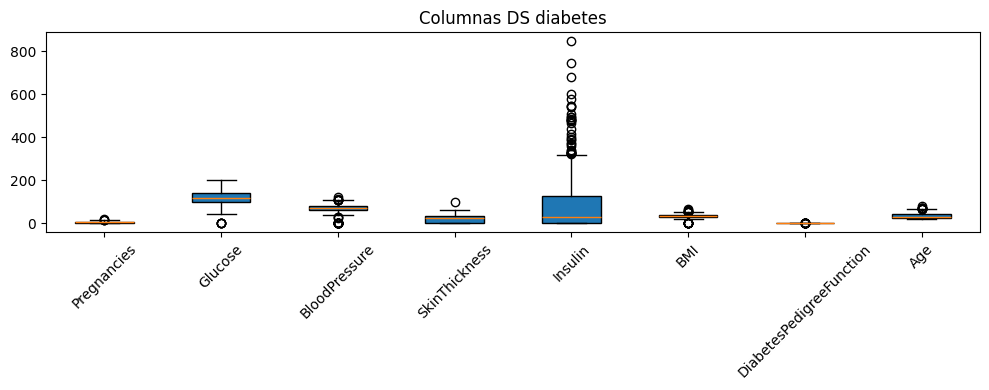

In [75]:
cols = [col for col in df.select_dtypes(include='number').columns if col != 'Outcome']

plt.figure(figsize=(10, 4))
plt.boxplot(df[cols].values, labels=cols, patch_artist=True)

plt.xticks(rotation=45)
plt.title('Columnas DS diabetes')
plt.tight_layout()
plt.show()

**Análisis de distribución general**

la distribución de los datos en términos generales estan en los rangos de 0 a 200 en todas las variables, a excepción del dato Insulin, el cual presenta una distribución mas amplia pero es debido al tipo de dato. De todas maneras, este ultimo presenta un grancandidad de Outlayes. por lo que se debe realizar un tratamiento a todos los datos para asegurar se deque los datos que estemos utilizando sean coherentes y no arriesgue la integridad del modelo.

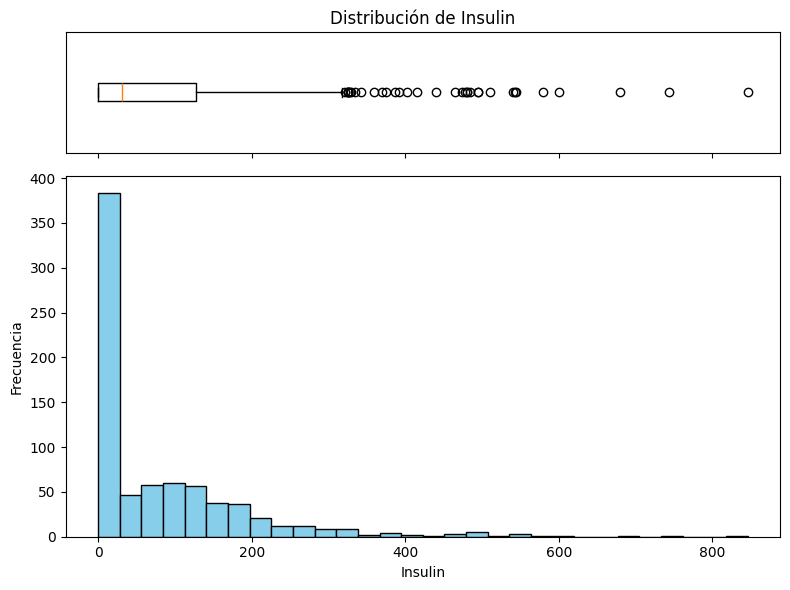

In [76]:
fig, (ax_box, ax_hist) = plt.subplots(
    nrows=2, 
    sharex=True, 
    gridspec_kw={"height_ratios": (0.25, 0.75)},
    figsize=(8, 6)
)
ax_box.boxplot(df['Insulin'], vert=False)
ax_box.set(title='Distribución de Insulin')
ax_box.set_yticks([]) 
ax_hist.hist(df['Insulin'], bins=30, color='skyblue', edgecolor='black')
ax_hist.set_xlabel('Insulin')
ax_hist.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()


**Análisis de "Insulin"**

El gráfico anterior reafirma que se debe realizar un tratameinto de outlayers, ya que no es normal que ina persona tenga 800 de insulina.

In [77]:
for i in df.columns[:]:
    print(i,'\n', df[i].unique(), '\n-------------------')

Pregnancies 
 [ 6  1  8  0  5  3 10  2  4  7  9 11 13 15 17 12 14] 
-------------------
Glucose 
 [148  85 183  89 137 116  78 115 197 125 110 168 139 189 166 100 118 107
 103 126  99 196 119 143 147  97 145 117 109 158  88  92 122 138 102  90
 111 180 133 106 171 159 146  71 105 101 176 150  73 187  84  44 141 114
  95 129  79   0  62 131 112 113  74  83 136  80 123  81 134 142 144  93
 163 151  96 155  76 160 124 162 132 120 173 170 128 108 154  57 156 153
 188 152 104  87  75 179 130 194 181 135 184 140 177 164  91 165  86 193
 191 161 167  77 182 157 178  61  98 127  82  72 172  94 175 195  68 186
 198 121  67 174 199  56 169 149  65 190] 
-------------------
BloodPressure 
 [ 72  66  64  40  74  50   0  70  96  92  80  60  84  30  88  90  94  76
  82  75  58  78  68 110  56  62  85  86  48  44  65 108  55 122  54  52
  98 104  95  46 102 100  61  24  38 106 114] 
-------------------
SkinThickness 
 [35 29  0 23 32 45 19 47 38 30 41 33 26 15 36 11 31 37 42 25 18 24 39 27
 21 34 10 

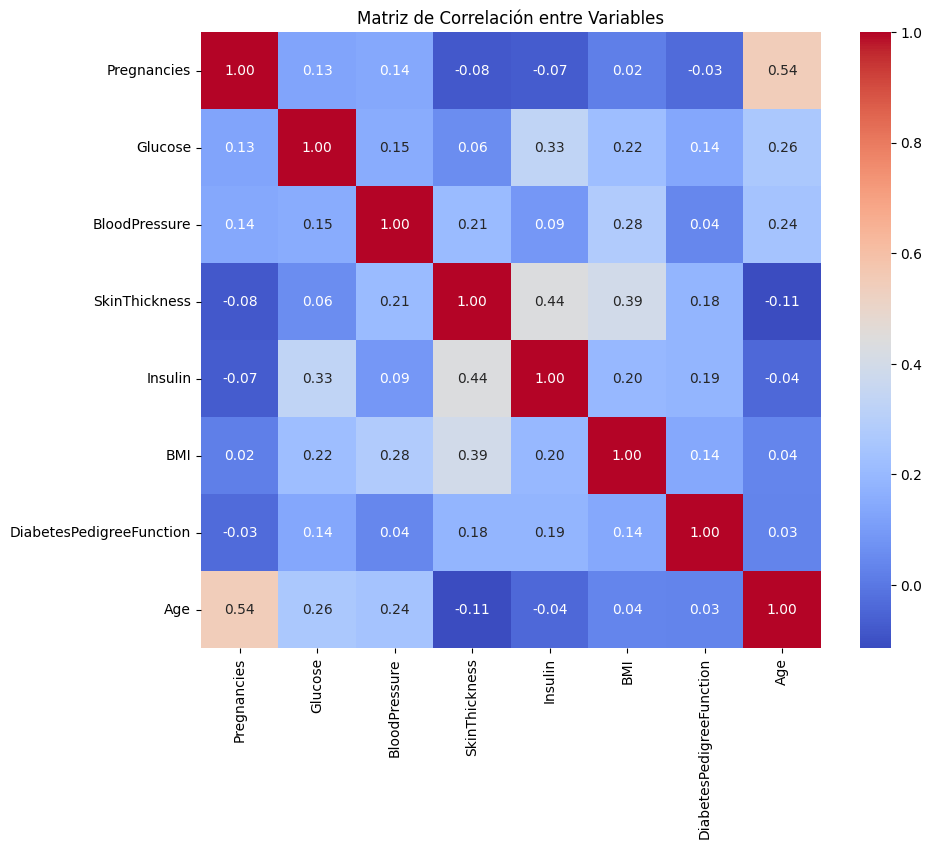

In [78]:
df_corr = df.drop('Outcome', axis=1)

# Calcular la matriz de correlación
corr_matrix = df_corr.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre Variables')
plt.show()

El analisis de la matriz de correlación revela que las relaciones entre variables numéricas del dataset son en su mayoría débiles o moderadas. La mayor correlación se observa entre Pregnancies y age (0.54), lo cual es esperable ya qeu a mayor edad, mayor cantidad de embarazos. También destaca la relación entre Insulin y SkinThickness (0.44), vinculada a la grasa corporal. El BMI y SkinThickness correlacionan en 0.39, indicando asociación entre masa corporal y grasa subcutánea. Las demás variables presentan correlaciones menores a 0.35, como glucose e Insulin (0.33) y Age con Glucose (0.26). Variables como DiabetesPedigreeFunction tienen correlación casi nula con el resto, lo que sugiere que aporta información distinta. En general, no hay multicolinealidad fuerte,  por lo que no es necesario eliminar variables por redundancia en este caso. Este panorama permite conservar todas las características para el modelado predictivo, y para esto, se escalarán las variables en el pipeline más adelante.

## **Principales hallazgos**

Valores duplicados: Debido al origen de los datos se aprecia que no hay ninguna columna que sea unica como un identificador, por lo que puede que existe la posibilidad de que hayan duplicados y sean válidos. Debido a esto, **no se eliminan duplicados**. 

Por otro lado, **no hay presencia de valores faltantes** en ninguno de los datos

Tipo de datos: Al ser todos los datos de tipo numérico, no se harán tratamientos para datos para categóricos como técnicas de one hot, o label encoding. Todos los datos corresponden al tipo identificado.

La proporción de valores en el Targest esta desbalanceada. se debe tener en cuenta algun medio para balancear esto en los modelos.

Hay un tema relevante en ceunto a los datos, hay muchos 0, en columnas como glucosa, presión de sangre entreotros, lo cuales es imposible que sean 0. si una persona tiene 0 de presión, estaría muerta. por lo que estos valores serán reemplazados por le media de cada columna


| ID | Dato                     | Tipo     | Problema        | Acción             |
|----| ------------------------ | -------- | --------------- | ------------------ |
| 01 | Pregnancies              | Numérica |Outlayers        | Tratamiento Outlayers y escalamiento             |
| 02 | Glucose                  | Numérica |Outlayers        | Tratamiento Outlayers y escalamiento            |
| 03 | BloodPressure            | Numérica |Outlayers        | Tratamiento Outlayers y escalamiento            |
| 04 | SkinThickness            | Numérica |Outlayers        | Tratamiento Outlayers y escalamiento            |
| 05 | Insulin                  | Numérica |Outlayers        | Tratamiento Outlayers y escalamiento            |
| 06 | BMI                      | Numérica |Outlayers        | Tratamiento Outlayers y escalamiento            |
| 07 | DiabetesPedigreeFunction | Numérica |Outlayers        | Tratamiento Outlayers y escalamiento            |
| 08 | Age                      | Numérica |Outlayers        | Tratamiento Outlayers y escalamiento            |
| 09 | Outcome                  | Binaria  |ninguno          | nada, todo bien             |



# Limpieza de datos

- Valores duplicados (no hay)
- Cambiar tipo de datos (todos estan correctos)
- valores nulos (no hay)
- tratamiento de outlayers


In [79]:
# Tratamiento de outlayers

# Los outlayesrs se reemplazarán por Nan, para que en el Pipeline sean imputados por la mediana, ya que es la estrategia más simple y esta no se ve afectada por los valores extremos
# y como se puede ver, ninguna variable tiene distribución simetrica.

for i in df.columns:
    if i != 'Outcome':
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        R = Q3-Q1
        L = Q1 - 1.5*R
        U = Q1 + 1.5*R
        df[i] = df[i].mask((df[i] < L) | (df[i] > U), np.nan)


In [80]:
df["Glucose"] = df["Glucose"].replace(0 , df["Glucose"].median())
df["BloodPressure"] = df["BloodPressure"].replace(0 , df["BloodPressure"].median())
df["SkinThickness"] = df["SkinThickness"].replace(0 , df["SkinThickness"].median())
df["Insulin"] = df["Insulin"].replace(0 , df["Insulin"].median())
df["BMI"] = df["BMI"].replace(0 , df["BMI"].mean())

In [81]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,682.000000,662.000000,670.000000,753.000000,671.000000,676.000000,671.000000,679.000000,768.000000
mean,2.994135,113.114804,70.486567,26.464807,45.813711,30.888166,0.375539,30.022091,0.348958
std,2.441075,22.350369,10.002494,8.356208,59.544511,5.327400,0.187833,7.853063,0.476951
min,0.000000,44.000000,38.000000,7.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,97.000000,64.000000,22.000000,0.000000,26.800000,0.232500,23.000000,0.000000
50%,2.000000,112.000000,70.000000,22.000000,0.000000,31.200000,0.328000,28.000000,0.000000
75%,5.000000,129.000000,78.000000,32.000000,92.000000,34.900000,0.520000,36.000000,1.000000
max,8.000000,160.000000,88.000000,48.000000,190.000000,41.200000,0.817000,49.000000,1.000000


# Split


In [82]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [83]:
# tipo de columnas
num_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

# Pre-Procesamiento

In [84]:
num_tr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

PreProcesamiento = ColumnTransformer(transformers=[
    ('num', num_tr, num_cols)
])

# Modelos

In [85]:
df_resultados = pd.DataFrame(columns=['Random Forest', 'XGBoost'],
                             index=['ACC', 'precision', 'Recall', 'F1'])

#### Random Forest

In [86]:
# random forest
Pipeline_RF = Pipeline([
    ('preprocessing', PreProcesamiento),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced')) # balance para el modelo
])

Pipeline_RF.fit(X_train, y_train)
y_pred= Pipeline_RF.predict(X_test)

# métricas
ACC = accuracy_score(y_test, y_pred)
PRE = precision_score(y_test, y_pred)
RCLL = recall_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)

df_resultados['Random Forest'] = [ACC, PRE, RCLL, F1]

print("\nMétricas para el modelo Random Forest:")
print(f"Accuracy: {ACC:.4f}")
print(f"Precision: {PRE:.4f}")
print(f"Recall: {RCLL:.4f}")
print(f"F1 score: {F1:.4f}")
print(classification_report(y_test, y_pred))
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))


Métricas para el modelo Random Forest:
Accuracy: 0.6948
Precision: 0.5714
Recall: 0.5818
F1 score: 0.5766
              precision    recall  f1-score   support

           0       0.77      0.76      0.76        99
           1       0.57      0.58      0.58        55

    accuracy                           0.69       154
   macro avg       0.67      0.67      0.67       154
weighted avg       0.70      0.69      0.70       154


Matriz de Confusión:
[[75 24]
 [23 32]]


#### XGboost

In [87]:
# XGBoost
Pipeline_XGB = Pipeline([
    ('preprocessing', PreProcesamiento),
    ('classifier', XGBClassifier(random_state=42,
                                 scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])))]) # Balance para el modelo

Pipeline_XGB.fit(X_train, y_train)
y_pred = Pipeline_XGB.predict(X_test)

# métricas
ACC = accuracy_score(y_test, y_pred)
PRE = precision_score(y_test, y_pred)
RCLL = recall_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)

df_resultados['XGBoost'] = [ACC, PRE, RCLL, F1]

print("\nMétricas para el modelo XGBoost:")
print(f"Accuracy: {ACC:.4f}")
print(f"Precision: {PRE:.4f}")
print(f"Recall: {RCLL:.4f}")
print(f"F1 score: {F1:.4f}")

print(classification_report(y_test, y_pred))

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))



Métricas para el modelo XGBoost:
Accuracy: 0.7078
Precision: 0.5714
Recall: 0.7273
F1 score: 0.6400
              precision    recall  f1-score   support

           0       0.82      0.70      0.75        99
           1       0.57      0.73      0.64        55

    accuracy                           0.71       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.71      0.71       154


Matriz de Confusión:
[[69 30]
 [15 40]]


# Comparación de rendimiento


In [88]:
df_resultados.T.sort_values(by='ACC')

,ACC,precision,Recall,F1
Random Forest,0.694805,0.571429,0.581818,0.576577
XGBoost,0.707792,0.571429,0.727273,0.640000


**Princiales resultados**

Como se aprecia en la tabla anterior, Random forest es el modelo que proporciona mejores resultados en cuanto al indicador Accuracy, y de igual manera con los otros indicadores. si bien este modelo es mejor que XGboost en este caso, la diferencia no es significativa. y ambos al estar realmtene cerca, se aplicará el método optuna pera conocer si mejoran o no los resultados con esta implementación.

#### Definición de parametros para optuna

In [89]:
# implementación de optuna
# Parámetros para el modelo xgboost y Random forest}

def optunaPorModelo(trial, modelo):
    if modelo == 'RF':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 1, 300),
            'max_depth': trial.suggest_int('max_depth', 1, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_float('max_features', 0.3, 1.0),
            'random_state': 42, 
            'class_weight':'balanced' #balnce de clases comentado
        }
        model = RandomForestClassifier(**params)

    if modelo == 'xgb':
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'n_estimators': trial.suggest_int('n_estimators', 1, 300),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0), 
            'use_label_encoder': False,
            'eval_metric': 'logloss',
            'random_state': 42,
            'scale_pos_weight': (y_train.value_counts()[0] / y_train.value_counts()[1]) # balance de clases comentaro
        }
        model = XGBClassifier(**params)
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])

    pipeline = Pipeline([
        ('preprocessing', PreProcesamiento),
        ('classifier', model)
    ])

    score = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1').mean()
    return score

#### Optuna para RF

In [90]:
# para random forest
study_RF = optuna.create_study(direction='maximize')
study_RF.optimize(lambda trial: optunaPorModelo(trial, modelo='RF'), n_trials=50)
print("Mejores hiperparámetros Random Forest:", study_RF.best_params)


[I 2025-07-18 22:59:03,250] A new study created in memory with name: no-name-7f4fcd29-d06b-48b8-a881-9d5a948d90ae
[I 2025-07-18 22:59:06,320] Trial 0 finished with value: 0.6040413516023271 and parameters: {'n_estimators': 224, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.8262729802659834}. Best is trial 0 with value: 0.6040413516023271.
[I 2025-07-18 22:59:08,261] Trial 1 finished with value: 0.6466443242475783 and parameters: {'n_estimators': 150, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 0.9474902518884065}. Best is trial 1 with value: 0.6466443242475783.
[I 2025-07-18 22:59:09,062] Trial 2 finished with value: 0.6348935239888573 and parameters: {'n_estimators': 64, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.7157002148380796}. Best is trial 1 with value: 0.6466443242475783.
[I 2025-07-18 22:59:11,677] Trial 3 finished with value: 0.6533322677681273 and parameters: {'n_es

Mejores hiperparámetros Random Forest: {'n_estimators': 7, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 0.6156278638124403}


In [91]:
study_RF.best_params

{'n_estimators': 7,
 'max_depth': 20,
 'min_samples_split': 6,
 'min_samples_leaf': 6,
 'max_features': 0.6156278638124403}

In [92]:
# random forest
Pipeline_RF_opt = Pipeline([
    ('preprocessing', PreProcesamiento),
    ('classifier', RandomForestClassifier(**study_RF.best_params))
])

Pipeline_RF_opt.fit(X_train, y_train)
y_pred= Pipeline_RF_opt.predict(X_test)

# métricas
ACC = accuracy_score(y_test, y_pred)
PRE = precision_score(y_test, y_pred)
RCLL = recall_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)

df_resultados['Random Forest_W_optuna'] = [ACC, PRE, RCLL, F1]

print("\nMétricas para el modelo Random Forest:")
print(f"Accuracy: {ACC:.4f}")
print(f"Precision: {PRE:.4f}")
print(f"Recall: {RCLL:.4f}")
print(f"F1 score: {F1:.4f}")
print(classification_report(y_test, y_pred))
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))


Métricas para el modelo Random Forest:
Accuracy: 0.7078
Precision: 0.5862
Recall: 0.6182
F1 score: 0.6018
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        99
           1       0.59      0.62      0.60        55

    accuracy                           0.71       154
   macro avg       0.68      0.69      0.69       154
weighted avg       0.71      0.71      0.71       154


Matriz de Confusión:
[[75 24]
 [21 34]]


#### Optuna XGBoost

In [93]:
# para para XGBoost

study_XGB = optuna.create_study(direction='maximize')
study_XGB.optimize(lambda trial: optunaPorModelo(trial, modelo='xgb'), n_trials=50)
print("Mejores hiperparámetros XGBoost:", study_XGB.best_params)


[I 2025-07-18 23:00:02,277] A new study created in memory with name: no-name-e9cd0008-6aca-41fb-b6de-a120cdd7e554
c:\Users\Bcaro\anaconda3\envs\USS\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:00:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Bcaro\anaconda3\envs\USS\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:00:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Bcaro\anaconda3\envs\USS\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:00:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Bcaro\anaconda3\envs\USS\Lib\site-packages\xgboost\training.py:183: UserWarning

Mejores hiperparámetros XGBoost: {'max_depth': 1, 'learning_rate': 0.1125767126246136, 'n_estimators': 179, 'subsample': 0.5930902230616528}


In [94]:
study_XGB.best_params

{'max_depth': 1,
 'learning_rate': 0.1125767126246136,
 'n_estimators': 179,
 'subsample': 0.5930902230616528}

In [95]:
Pipeline_XGB_opt = Pipeline([
    ('preprocessing', PreProcesamiento),
    ('classifier', XGBClassifier(**study_XGB.best_params))])

Pipeline_XGB_opt.fit(X_train, y_train)
y_pred = Pipeline_XGB_opt.predict(X_test)

# métricas
ACC = accuracy_score(y_test, y_pred)
PRE = precision_score(y_test, y_pred)
RCLL = recall_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)

df_resultados['XGBoost_W_optuna'] = [ACC, PRE, RCLL, F1]

print("\nMétricas para el modelo XGBoost:")
print(f"Accuracy: {ACC:.4f}")
print(f"Precision: {PRE:.4f}")
print(f"Recall: {RCLL:.4f}")
print(f"F1 score: {F1:.4f}")

print(classification_report(y_test, y_pred))

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))


Métricas para el modelo XGBoost:
Accuracy: 0.7403
Precision: 0.6154
Recall: 0.7273
F1 score: 0.6667
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        99
           1       0.62      0.73      0.67        55

    accuracy                           0.74       154
   macro avg       0.72      0.74      0.73       154
weighted avg       0.75      0.74      0.74       154


Matriz de Confusión:
[[74 25]
 [15 40]]


In [96]:
df_resultados.T.sort_values(by='ACC')

,ACC,precision,Recall,F1
Random Forest,0.694805,0.571429,0.581818,0.576577
XGBoost,0.707792,0.571429,0.727273,0.640000
Random Forest_W_optuna,0.707792,0.586207,0.618182,0.601770
XGBoost_W_optuna,0.740260,0.615385,0.727273,0.666667


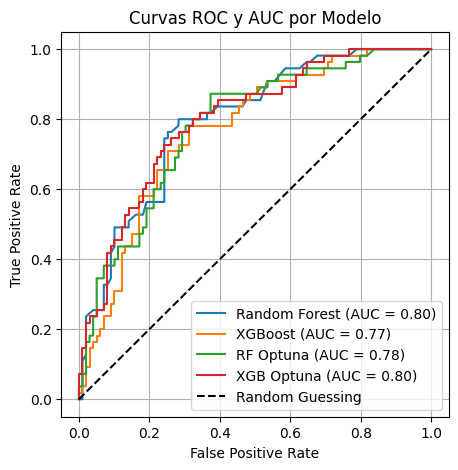

In [98]:
plt.figure(figsize=(5, 5))


y_prob_rf = Pipeline_RF.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')

y_prob_xgb = Pipeline_XGB.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')

y_prob_rf_opt = Pipeline_RF_opt.predict_proba(X_test)[:,1]
fpr_rf_optuna, tpr_rf_optuna, _ = roc_curve(y_test, y_prob_rf_opt)
auc_rf_optuna = roc_auc_score(y_test, y_prob_rf_opt)
plt.plot(fpr_rf_optuna, tpr_rf_optuna, label=f'RF Optuna (AUC = {auc_rf_optuna:.2f})')

y_prob_xgb_opt = Pipeline_XGB_opt.predict_proba(X_test)[:,1]
fpr_xgb_optuna, tpr_xgb_optuna, _ = roc_curve(y_test, y_prob_xgb_opt)
auc_xgb_optuna = roc_auc_score(y_test, y_prob_xgb_opt)
plt.plot(fpr_xgb_optuna, tpr_xgb_optuna, label=f'XGB Optuna (AUC = {auc_xgb_optuna:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC y AUC por Modelo')
plt.legend()
plt.grid(True)
plt.show()


Los indicadores muestran que el modelo **Random Forest optimizado con Optuna** fue el que presentó mejor desempeño en todas las pruebas iniciales, con un desempeño consistente y estable. Sin embargo, al comparar métricas específicas, el modelo **XGBoost optimizado con Optuna** alcanzó el mejor **accuracy (74%)** y el mayor **F1-score (0.67)**, reflejando un mejor balance entre precisión y recall. En particular, XGBoost logró un mayor recall, lo que es crucial para detectar casos positivos de diabetes, aunque con una precisión moderada que indica algunos falsos positivos. En resumen, ambos modelos optimizados mejoraron notablemente respecto a sus versiones base, destacando la importancia de la optimización en el desempeño final.
